<a href="https://colab.research.google.com/github/Arseniy-Polyakov/applied_linguistics_course/blob/main/Task_4_Sentiment_Analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Данная работа посвящена сентимент-анализу русских финансовых новостей на основе [датасета](https://huggingface.co/datasets/Kasymkhan/RussianFinancialNews) с помощью алгоритма рандомного леса, обученного на [датасете](https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset) размеченных текстов. В ходе работы будет доказана или опровергнута гипотеза о том, что сентимент русских новостей прямо зависим от цикличности экономики (во время роста экономики будет наблюдаться положительный сентимент, во время рецессии отрицательный, а по время стагнации нейтральный)

Импортируем модули для предобработки текста, векторизации, обучения модели

In [1]:
import re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

Загружаем датасет финансовых новостей

In [2]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_financial = pd.read_parquet("hf://datasets/Kasymkhan/RussianFinancialNews/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df_financial.head()

,title,body,date,time,tags,source,__index_level_0__
0,no title,Российские отели «всё включено» обяжут предлаг...,2023-03-10,not stated,no tags,smart_lab,68555
1,no title,""" Самолет (SMLT) в 4кв2023 собирается побить р...",2023-10-26,08:31:24,"['аналитика', 'факты']",rdv,2032
2,no title,"""Высокие цены на нефть, похоже, надолго. Мир в...",2022-08-29,11:56:47,"['ROSN', 'LKOH']",rdv,4891
3,no title,ЦБ определил порядок продажи заблокированных и...,2023-12-11,not stated,no tags,smart_lab,78666
4,Подборка замещающих облигаций в евро: доходнос...,Чем привлекателен выпуск Газпром Капитала,2024-01-12 00:00:00,13:51,['Газпром капитал ЗО28-1-Е RU000A105BY1'],bcs,39150


In [4]:
texts_for_analysis = list(df_financial["body"])
texts_for_analysis

['Российские отели «всё включено» обяжут предлагать гостям отечественный алкоголь во время обедов и ужинов, объём будет неограничен',
 '" Самолет (SMLT) в 4кв2023 собирается побить рекорд 3кв. Менеджмент подтверждает цель в 1 600 тыс. кв. м продаж за весь 2023 год. #аналитика #факты Видимо, менеджмент видит уже по октябрьским цифрам, что даже после роста ключевой ставки продажи на первичке идут хорошо. Первичный рынок, особенно массовый сегмент, на котором работает Самолет — бенефициар программ льготной ипотеки. Цель на год 1600 кв.м.: • по итогам 9 месяцев есть 973 тыс. кв. м. • консолидация МИЦ даст примерно 100 тыс. кв. м • таким образом, продажи Самолёта без МИЦ в 4 квартале могут составить порядка 527 тыс. кв. м - на 25% больше, чем в рекордном 3кв2023.  "',
 '"Высокие цены на нефть, похоже, надолго. Мир в последние годы, понадеявшись на зелёную энергетику, недоинвестировал в добычу нефти, что привело к дефициту. Это признал даже Илон Маск, вот что он сказал сегодня на форуме в Но

Загружаем [датасет](https://huggingface.co/datasets/MonoHime/ru_sentiment_dataset) размеченных текстов с эмоциональным тэгом (0 - нейтральный, 1 - позитивный, 2 - негативный) для обучения алгоритма рандомного леса

In [5]:
splits = {'train': 'train.csv', 'validation': 'valid.csv'}
df_sentiment = pd.read_csv("hf://datasets/MonoHime/ru_sentiment_dataset/" + splits["train"])
df_sentiment.head()

,Unnamed: 0,text,sentiment
0,21098,".с.,и спросил его: о Посланник Аллаха!Ты пори...",1
1,21099,Роднее всех родных Попала я в ГКБ №8 еще в дек...,1
2,21100,Непорядочное отношение к своим работникам Рабо...,2
3,21101,"). Отсутствуют нормативы, Госты и прочее, что ...",1
4,21102,У меня машина в руках 5 лет и это п...,1


In [6]:
texts_sentiment = list(df_sentiment["text"])
texts_sentiment

['.с.,и спросил его:  о Посланник Аллаха!Ты порицаешь что-то из слушания?  Он ответил: я не порицаю ничего из него,но передай им,чтобы они открывали свои собрания Кораном и закрывали их Кораном ...........Это дошедшие до нас мнения и тот кто находится в поисках истины,по мере изучения этого вопроса будет сталкиваться с разногласиями и будет оставаться в растерянности или склонится к мнению одной из сторон по своему желанию.Но всего этого недостаточно,потому что он сам должен найти истину,подробно изучив вопросы запретного и разрешённого.|||||||||||||||||||||||||||||||||||||Обрати внимание:основатели всех четырёх мазхабов осуждали песни и поэззию.И этим часто грешат заблудшие суфии.Исключение делается для исламской тематики  Сахих БухариО проявлении радости во время праздника.498 (949). Сообщается, что ‘Аиша, да будет доволен ею Аллах, сказала: (Однажды) посланник Аллаха, да благословит его Аллах и приветствует, вошёл ко мне в то время, когда у меня находились две девушки, певшие песню 

Подготовим метки для нашей модели, векторизуем категориальные метки с помощью алгоритма label encoder

In [7]:
encoder = LabelEncoder()
labels = np.array(df_sentiment["sentiment"])
encoded_labels = encoder.fit_transform(labels)
encoded_labels

array([1, 1, 2, ..., 0, 0, 1])

Создадим объект для векторизации размеченных текстов. В качестве векторизатора будем использовать [дистиллированную модель rubert](cointegrated/rubert-tiny), обученную на НКРЯ, русскоязычной википедии, корпусе Тайга. Данная модель запускается на облачных ускорителях google colab и позволяет не превышать допустимые объемы оперативной памяти и осуществить относительно быструю и качественную векторизацию текстов

In [ ]:
model_encoder = SentenceTransformer("cointegrated/rubert-tiny")

Преобразуем тексты из размеченного датасета в эмбеддинги с помощью модели

In [9]:
embeddings = model_encoder.encode(texts_sentiment)

In [10]:
len(embeddings)

189891

Разделим тексты из датасета на обучающую и тестовую выборки в соотношении 80/20

In [11]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, encoded_labels, test_size=0.2, random_state=42)

Обучим модель машинного обучения (ансамблевый алгоритм рандомного леса) для классификации текстов в зависимости от их сентимента (3 категории: негативные, нейтральные и положительные тексты)

In [ ]:
model_classificator = RandomForestClassifier(n_estimators=100)
model_classificator.fit(X_train, y_train)

Предскажем результаты тестовой выборки с помощью обученной модели

In [13]:
y_pred = model_classificator.predict(X_test)

Оценим метрики качества модели, в качестве эталона возьмем среднее гармоническое между precision и recall, f1-меру

In [14]:
result = classification_report(y_pred, y_test)
f1_model = f1_score(y_pred, y_test, average="micro")
f1_model

0.6894073040364412

Интерпретация результатов: f1-мера рандомного леса, обученного на датасете ru_sentiment_dataset, векторизованного моделью cointegrated/rubert-tiny, составляет 0.69. Согласно [лидерборду](https://github.com/sismetanin/sentiment-analysis-in-russian?ysclid=mc2laax2dg800656083) среднее значение f1-меры моделей русского сентимент-анализа на датасете ru_sentiment составляет от 0.69 до 0.78 (модель в библиотеке dostoevsky, согласно [официальным данным](https://github.com/bureaucratic-labs/dostoevsky?tab=readme-ov-file) на платформе Github, составляет 0.71) Это означает, что наша обученная модель валидная и может быть использована для определения сентимента текстов финансовых новостей на русском языке

Определим метки сентимента на датасете финансовых новостей на нашей модели

In [ ]:
embedding_for_analysis = model_encoder.encode(texts_for_analysis)

In [ ]:
labels_random_forest = model_classificator.predict(embedding_for_analysis)
labels_random_forest

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
labels_dict = {
    0: 0,
    1: -1,
    2: 1
}
labels_random_forest_normalized = [labels_dict[label] for label in labels_random_forest]

In [ ]:
dates = df_financial["date"].tolist()

In [ ]:
sentiment_dates = []
for i in range(len(dates)):
  sentiment_dates.append((datetime.datetime.strptime(dates[i].split()[0], "%Y-%m-%d"), labels_random_forest_normalized[i]))
sentiment_dates_sorted = sorted(sentiment_dates, key=lambda x:x[0])
len(sentiment_dates_sorted)

73564

In [ ]:
def number_to_month(number_month: int) -> str:
  months = {
      1: "январь",
      2: "февраль",
      3: "март",
      4: "апрель",
      5: "май",
      6: "июнь",
      7: "июль",
      8: "август",
      9: "сентябрь",
      10: "октябрь",
      11: "ноябрь",
      12: "декабрь"
  }
  return months[number_month]

In [ ]:
sentiment_dates_by_month = {}
i = 0
while i < 72570:
  month_agr = []
  if sentiment_dates_sorted[i][0].month == sentiment_dates_sorted[i+1][0].month:
    while sentiment_dates_sorted[i][0].month == sentiment_dates_sorted[i+1][0].month:
      month_agr.append(sentiment_dates_sorted[i][1])
      i += 1
    sentiment_dates_by_month[str(sentiment_dates_sorted[i][0].year) + " " + number_to_month(sentiment_dates_sorted[i][0].month)] = round(sum(month_agr) / len(month_agr), 2)
    i += 1
  else:
    sentiment_dates_by_month[str(sentiment_dates_sorted[i][0].year) + " " + number_to_month(sentiment_dates_sorted[i][0].month)] = sentiment_dates_sorted[i][1]
    i += 1
sentiment_dates_by_month


{'2011 январь': -1,
 '2011 апрель': 0.0,
 '2011 июль': -1,
 '2011 август': 0.2,
 '2011 октябрь': 0.0,
 '2011 ноябрь': 0.18,
 '2011 декабрь': -0.11,
 '2012 январь': -0.43,
 '2012 февраль': 0.0,
 '2012 октябрь': 0.12,
 '2012 ноябрь': -0.06,
 '2012 декабрь': -0.06,
 '2013 январь': 0.0,
 '2013 февраль': -0.06,
 '2013 март': -0.06,
 '2013 апрель': -0.12,
 '2013 май': -0.09,
 '2013 июнь': -0.09,
 '2013 июль': -0.11,
 '2013 август': -0.33,
 '2013 сентябрь': -0.12,
 '2013 октябрь': -0.05,
 '2013 ноябрь': -0.1,
 '2013 декабрь': -0.25,
 '2014 январь': -0.07,
 '2014 февраль': -0.14,
 '2014 март': -0.47,
 '2014 апрель': -0.27,
 '2014 май': -0.38,
 '2014 июнь': 0.0,
 '2014 июль': 0.0,
 '2014 август': 0.5,
 '2014 октябрь': 0,
 '2015 сентябрь': 0,
 '2016 январь': 0,
 '2016 декабрь': 0,
 '2017 январь': 0.25,
 '2017 февраль': 0,
 '2017 март': -1,
 '2017 апрель': 1,
 '2017 май': 0,
 '2017 июнь': 0,
 '2017 июль': 0,
 '2017 август': -0.33,
 '2017 сентябрь': 0,
 '2017 октябрь': 0,
 '2018 январь': 0,
 '2018

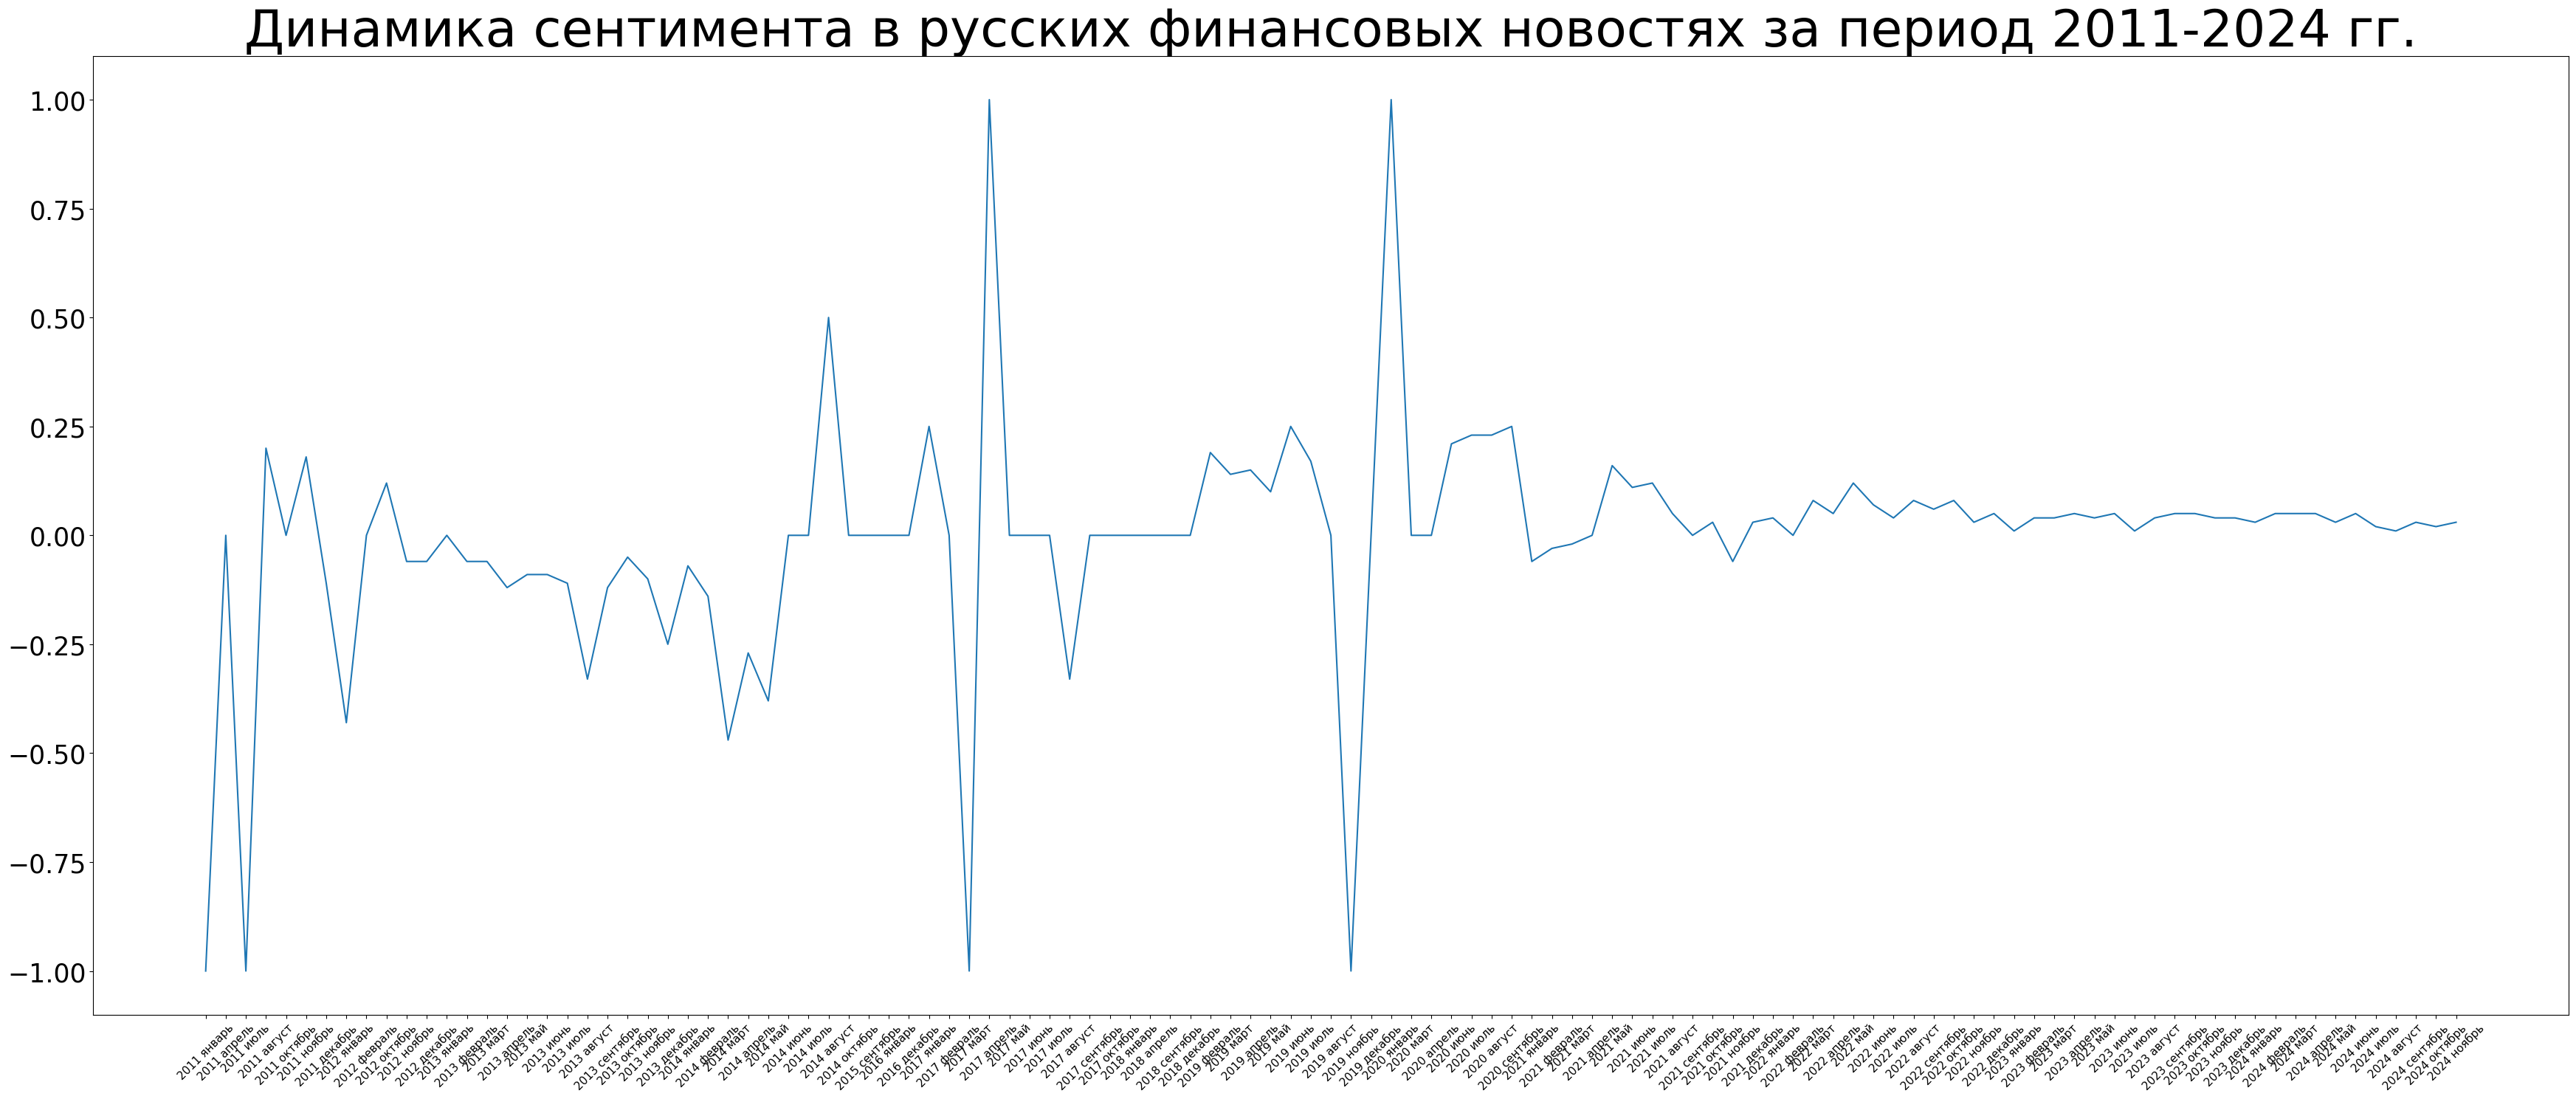

In [ ]:
plt.figure(figsize=(35, 15))
plt.plot(list(sentiment_dates_by_month.keys()), list(sentiment_dates_by_month.values()))
plt.title("Динамика сентимента в русских финансовых новостях за период 2011-2024 гг.", fontsize=50)
plt.yticks(fontsize=25)
plt.xticks(rotation=45, fontsize=11)
plt.tight_layout()
plt.show()

Исходя из анализа графика можно определить четыре глобальных минимума (январь 2011 года, апрель 2011 года, февраль 2017 года, август 2019 года) и два глобальных максимума (март 2017 года, ноябрь 2019 года).

Резкие изменения в 2011 году (от строго негативного к нейтральному сентименту) можно объяснить дуализмом в экономической ситуации: с одной стороны инфляция была на рекодно низком уровне, начиная с 1991 года, 6,1%, экономика находилась в стадии роста после кризиса 2008 года. Однако среди негативных факторов отмечают низкий рост доходов населения, а спрос поддерживался за счет потребительского кредитования, а не роста доходов населения ([Источник](https://riarating.ru/files/ratings/macro_13.pdf)).

Глобальный минимум февраля 2017 года но многом обуславливается уменьшением ВВП по сравнению с предыдущим годом ([Источник](https://www.finam.ru/publications/item/veb-zafiksiroval-snizhenie-vvp-rf-v-fevrale-2017-goda-na-1-5-20170331-190123/)).

Глобальный минимум августа 2019 года частично можно объяснить слабой инвестиционной активностью, сдержанным потребительским спросом и сокращением рабочей силы ([Источник](https://cbr.ru/collection/collection/file/23715/ec_2019-08.pdf)). Однако нельзя оценить данный период как резко негативный (по сравнению с другими периодами финансовый рынок был в наиболее худшем состоянии).

Глобальный максимум марта 2017 года можно объяснить прекращением снижения ВВП по отношению к предыдущему месяцу, снижением ключевой ставки до 9,75% годовых ([Источник](https://cbr.ru/collection/collection/file/7831/2017_01_ddcp.pdf)).

Глобальный максимум ноября 2019 года сложно подтвердить фактами, так как это период выделяют как стагнационный и в некоторых аспектах негативный (замедление роста промышленного производства, а также инвестиций, в связи с завершением главных объектов года: Крымского моста и газопровода Сила Сибири).

Вывод: алгоритмы машинного обучения, классификаторы, определяющие сентимент на основе размеченных датасетов могут быть использованы в качестве диахронического анализа экономической, финансовой, политической ситуации на основе новостей.
Однако есть несколько факторов, которые снижают качество классификации модели (на что свидетельствуют несоответствия глобальных минимумов / максимумов общей экономической ситуации): репрезентативность, полнота и сфера датасета (ru_sentiment преимущественно собран на основе разговорных текстов: токсичные комментарий с порталов 2ch, pikabu; отзывы об отелях и т.п.). Новости из мира финансов и экономики написаны преимущественно формальным языком, что усложняет качество классификации. Также есть гипотеза о том, что модель может путать положительные и отрицательные динамики, присваивая им протиположные значения, если эти динамики относятся не к самим популярным понятиям (например: рост издержек)